In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data

## Import

In [2]:
dataset = pd.read_csv('Mall_Customers.csv')
dataset.sample(5)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
191,192,Female,32,103,69
169,170,Male,32,87,63
10,11,Male,67,19,14
4,5,Female,31,17,40
28,29,Female,40,29,31


In [3]:
dataset.describe(include='all')

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


In [4]:
X = dataset.iloc[:,1:].values

## Missing Data

In [5]:
dataset.isna().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## Encoding

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [7]:
X[:5]

array([['Male', 19, 15, 39],
       ['Male', 21, 15, 81],
       ['Female', 20, 16, 6],
       ['Female', 23, 16, 77],
       ['Female', 31, 17, 40]], dtype=object)

In [8]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X[:5]

array([[0.0, 1.0, 19, 15, 39],
       [0.0, 1.0, 21, 15, 81],
       [1.0, 0.0, 20, 16, 6],
       [1.0, 0.0, 23, 16, 77],
       [1.0, 0.0, 31, 17, 40]], dtype=object)

# Clustering

## Elbow method

In [9]:
from sklearn.cluster import KMeans

In [10]:
wcss = []

for c in range(1,11):
    kmeans = KMeans(n_clusters=c,random_state=42,init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

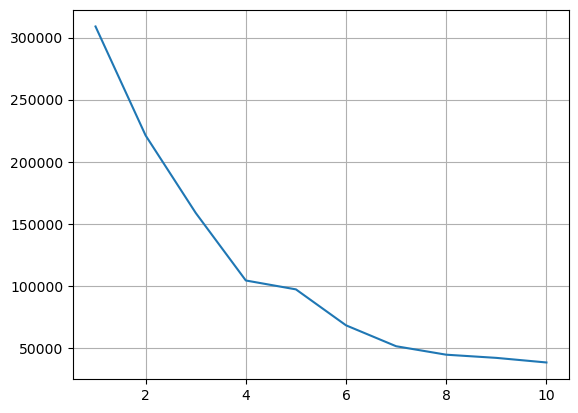

In [11]:
plt.plot(range(1,11),wcss)
plt.grid()

## Training

In [12]:
kmeans = KMeans(n_clusters=4,random_state=42,init='k-means++')
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

## Predicting

In [13]:
y = kmeans.predict(X)
y.shape

(200,)

## Visualising 

In [14]:
# Reducing to 2 dimensions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(kmeans.cluster_centers_)

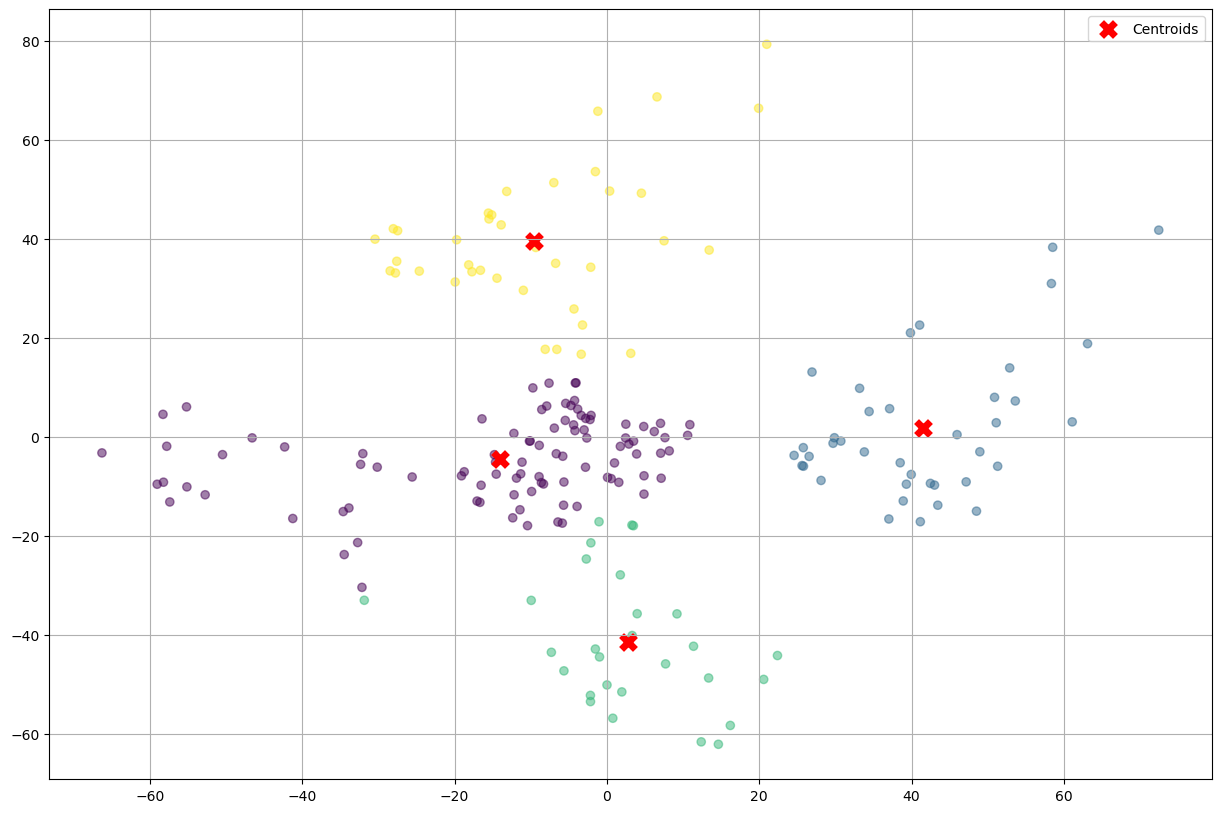

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap='viridis',alpha=.5)
plt.scatter(centroids_pca[:,0],centroids_pca[:,1],c='red',marker='x',s=100,label='Centroids',linewidths=5)
plt.legend()
plt.grid()

In [25]:
dataset['cluster'] = y

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
 5   cluster                 200 non-null    int32 
dtypes: int32(1), int64(4), object(1)
memory usage: 8.7+ KB


In [44]:
dataset.pivot_table(values=['Age','Annual Income (k$)','Spending Score (1-100)'],
                    index=['cluster'],aggfunc=['median','max','min','mean'])

median                                           max  \
           Age Annual Income (k$) Spending Score (1-100) Age   
cluster                                                        
0         48.0               54.0                   47.0  70   
1         32.0               79.0                   83.0  40   
2         23.0               28.0                   74.0  35   
3         41.5               80.0                   16.5  59   

                                                  min                     \
        Annual Income (k$) Spending Score (1-100) Age Annual Income (k$)   
cluster                                                                    
0                       69                     60  18                 16   
1                      137                     97  27                 69   
2                       48                     99  18                 15   
3                      137                     40  19                 70   

                                     mean                     \
        Spending Score (1-100)        Age Annual Income (k$)   
cluster                                                        
0                            3  44.894737          48.705263   
1                           63  32.692308          86.538462   
2                           39  24.821429          28.714286   
3                            1  40.394737          87.000000   

                                
        Spending Score (1-100)  
cluster                         
0                    42.631579  
1                    82.128205  
2                    74.250000  
3                    18.631579

In [56]:
genre_summ = dataset.groupby(['cluster','Genre']).count()[['CustomerID']].unstack(level=1)['CustomerID']
genre_summ['Prop Fem'] = genre_summ['Female']/genre_summ.sum(axis=1)
genre_summ

Genre,Female,Male,Prop Fem
cluster,,,
0,59,36,0.621053
1,21,18,0.538462
2,14,14,0.500000
3,18,20,0.473684
